In [1]:
import warnings; warnings.filterwarnings("ignore", message="Initializing zero-element tensors is a no-op")
import pandas as pd
import torch

from eval_utils import get_pairs, eval_epochs, MNISTSingleDataset

import sys
sys.path.insert(0, '../')

from utils import aug_transform, simple_transform
from models.mini_inception_resnet_v1 import MiniInceptionResNetV1
from models.omoindrot import TripletNetwork

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMAGES_PATH = '../data/'
EPOCHS_PATH = '../checkpoints/'

In [2]:
test_df = pd.read_csv('../data/mnist_test.csv')
print(f'Test data shape: {test_df.shape}')

pairs = get_pairs(test_df, 1000)
print(f'Pairs shape: {pairs.shape}')

Test data shape: (10000, 785)
Pairs shape: (1000, 3)


In [3]:
pairs.head(1)

,img1,img2,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [ ]:
eval_epochs(epochs_path=EPOCHS_PATH, 
            pairs=pairs,
            model_class=TripletNetwork, 
            batch_size=32, 
            transform=simple_transform, 
            device=device,
            target_far=1e-3)

# **Visualizar os embeddings**

In [3]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomAffine

In [4]:
# Extrair embeddings para o conjunto de teste
model = TripletNetwork(emb_size=64).to(device)

load = torch.load(EPOCHS_PATH + 'epoch_20.pt')
load = {k.replace('_orig_mod.', ''): v for k, v in load.items()}
model.load_state_dict(load)

<All keys matched successfully>

In [5]:
test_dataset = MNISTSingleDataset(test_df, transform=simple_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=0)

# Extrair embeddings
model.eval()

embeddings = []
with torch.no_grad():
    for (imgs, labels) in test_dataloader:
        images = imgs.to(device)
        embeddings.append(model(images).cpu().numpy())
        
embeddings = np.concatenate(embeddings)

In [7]:
# Reduzir dimensionalidade
tsne = TSNE(n_components=2, perplexity=30, max_iter=300)

embeddings_2d = tsne.fit_transform(embeddings)

/home/lucca-wsl/ML/facenet/facenet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


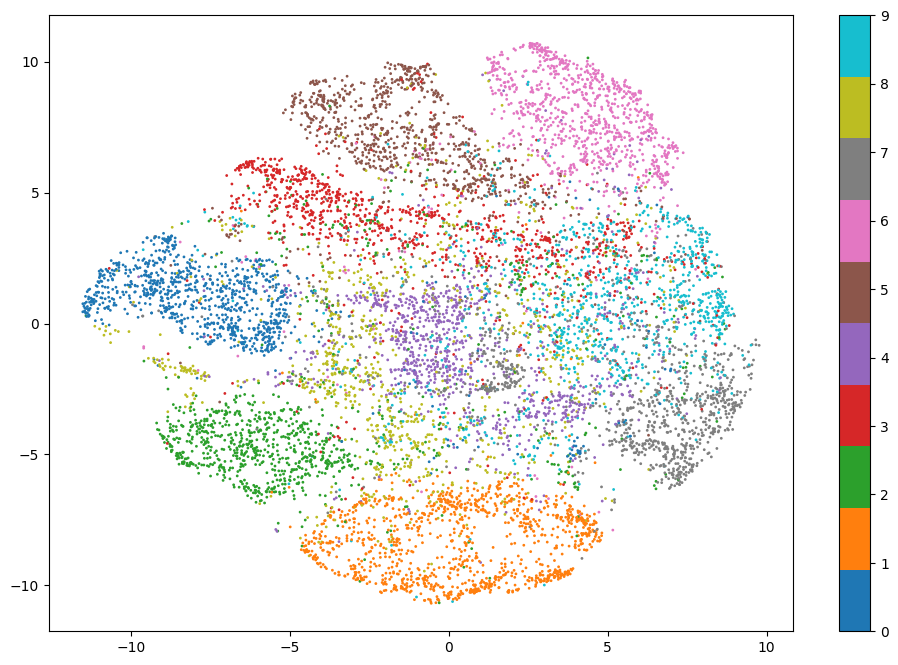

In [14]:
# Plotar embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=test_df['label'], cmap='tab10', s=1)
plt.colorbar()
plt.show()


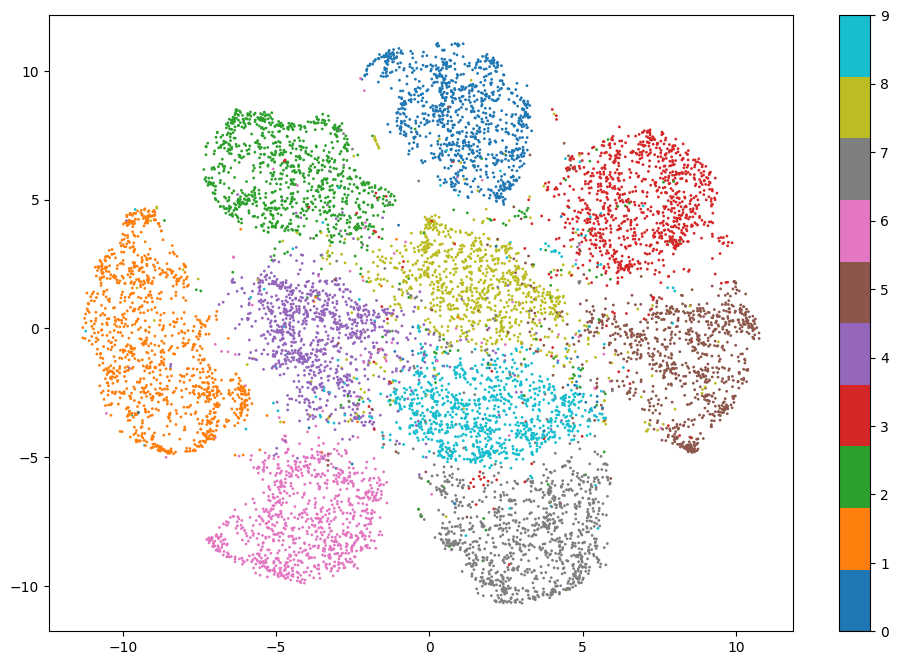

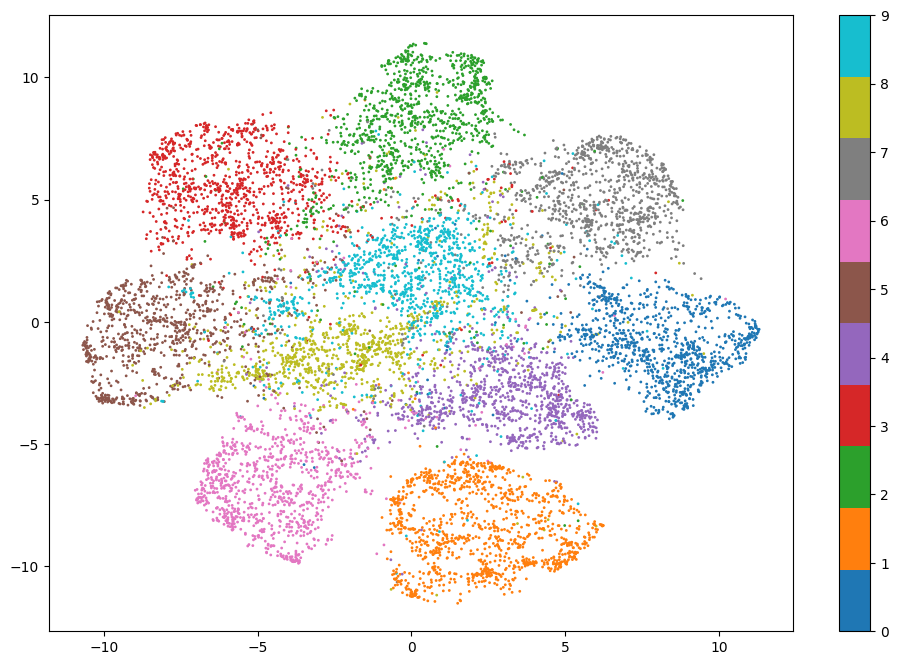

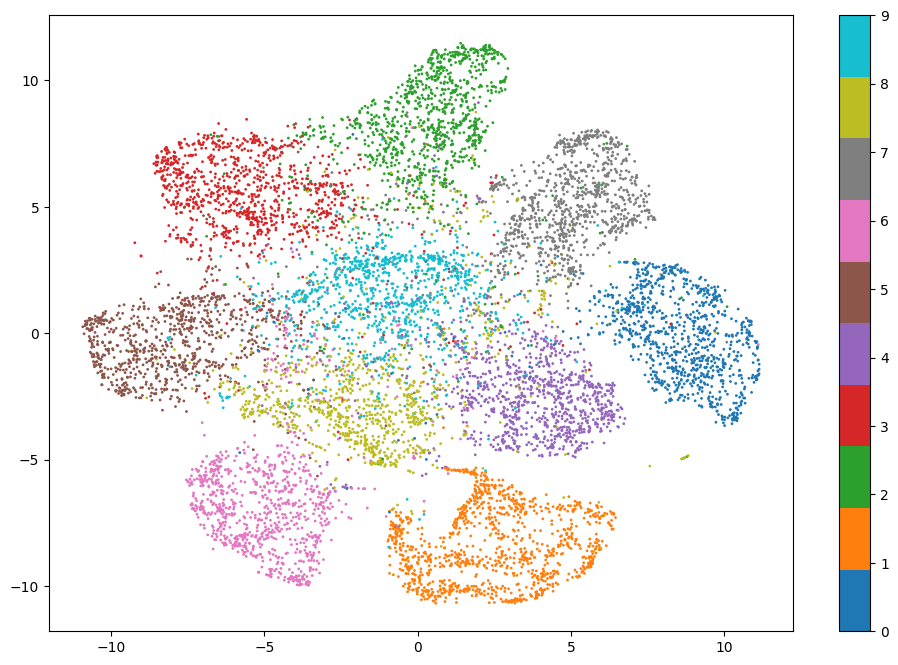

KeyboardInterrupt: 

In [16]:
import os

def view_embs(epochs_path, model_class):
    models_name = os.listdir(epochs_path)
    models_name_sorted = sorted(models_name, key=lambda x: int(x.replace('.pt', '').split('_')[1]))
        
    modelo = model_class(emb_size=64).to(device)
    modelo.eval()
    
    test_dataset = MNISTSingleDataset(test_df, transform=simple_transform)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=0)
    
    for model in models_name_sorted:        
        model_path = os.path.join(epochs_path, model)
        load = torch.load(model_path)
        load = {k.replace('_orig_mod.', ''): v for k, v in load.items()}
        modelo.load_state_dict(load)

        embeddings = []
        with torch.no_grad():
            for (imgs, labels) in test_dataloader:
                images = imgs.to(device)
                embeddings.append(modelo(images).cpu().numpy())

        embeddings = np.concatenate(embeddings)
        
        # Reduzir dimensionalidade
        tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Plotar embeddings
        plt.figure(figsize=(12, 8))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=test_df['label'], cmap='tab10', s=1)
        plt.colorbar()
        plt.show()
        
view_embs(EPOCHS_PATH, TripletNetwork)